In [2]:
#all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from collections import defaultdict

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI

best_k = 8 #change for different case


Text_Numeracy = "In a few sentences, please describe an experience in your life that demonstrated your knowledge of health or medical issues."
Text_Anxiety = "In a few sentences, please describe what makes you feel most anxious or worried when visiting the doctor's office."
Text_TrustPhys = "In a few sentences, please explain the reasons why you trust or distrust your primary care physician. If you do not have a primary care physician, please answer in regard to doctors in general."
Text_SubjectiveLit = "Regarding all the questions you just answered, to what degree do you feel you have the capacity to obtain, process, and understand basic health information and services needed to make appropriate health decisions? Please explain your answer in a few sentences."

## Table for demographic/behavioral/psychological features

In [2]:
# 文件路径
file_path = 'Data\Data_SurveyPlusDemographics.txt'

# 读取文件
data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')

data = data.dropna()

# Display the remaining number of rows after dropping missing values
remaining_rows = data.shape[0]
print(f'Remaining number of rows after dropping missing values: {remaining_rows}')

# 显示数据的前几行
print(data.head())

Remaining number of rows after dropping missing values: 8120
   File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...   D6  Dmed_7  \
0     1    1  5.0  5.0  4.0   5  3.0  1.0    3    1.0  ...  1.0    30.0   
1     1    2  4.0  4.0  4.0   4  3.0  1.0    3    2.0  ...  1.0    29.0   
2     1    3  5.0  5.0  4.0   4  3.0  1.0    3    1.0  ...  1.0    32.0   
3     1    4  5.0  5.0  4.0   4  3.0  4.0    3    1.0  ...  1.0    31.0   
4     1    5  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...  1.0    34.0   

   Dmed_8 DMed_1  DMed_2  DMed_3  DMed_9  Dmed_10  Dmed_5  Dmed_6  
0     152    4.0     1.0     4.0     3.0      5.0     1.0     1.0  
1     150    3.0     1.0     8.0     3.0      6.0     1.0     1.0  
2     160    1.0     1.0     4.0     6.0      5.0     1.0     1.0  
3     168    5.0     1.0    12.0     2.0      5.0     1.0     3.0  
4     220    5.0     1.0    12.0     3.0      4.0     7.0    15.0  

[5 rows x 123 columns]


C:\Users\howar\AppData\Local\Temp\ipykernel_23956\533319393.py:5: DtypeWarning: Columns (115) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')


In [3]:
demographic_list = [
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "D6",
    "Dmed_7",
    "Dmed_8"
]


behavioral_list  = [
    "DMed_1",
    "DMed_2",
    "DMed_3",
    "DMed_9",
    "Dmed_10",
    "Dmed_5",
    "Dmed_6",
    "HC_1",
    "HC_2",
    "HC_3",
    "HC_4",
    "HC_5",
    "Rx2"
]



psychological_list = [
    "ATQ_1",
    "ATQ_2",
    "ATQ_3",
    "ATQ_4",
    "ATQ_5",
    "ATQ_6",
    "ATQ_7",
    "ATQ_8",
    "TWB_1",
    "TWB_2",
    "TWB_3",
    "TWB_4",
    "TWB_5",
    "TWB_6",
    "TWB_7",
    "TWB_8",
    "TWB_9",
    "TWB_10",
    "RA1_1",
    "RA1_2",
    "RA1_3",
    "RA1_4",
    "RA1_5",
    "RA1_6",
    "RA1_7",
    "RA1_8",
    "RA1_9",
    "RA1_10",
    "STAI_1",
    "STAI_2",
    "STAI_3",
    "STAI_4",
    "STAI_5",
    "STAI_6",
    "STAI_7",
    "BSCS_1",
    "BSCS_2",
    "BSCS_3",
    "BSCS_4",
    "REI_1",
    "REI_2",
    "REI_3",
    "REI_4",
    "REI_5",
    "REI_6",
    "REI_7",
    "REI_8",
    "REI_9",
    "REI_10",
    "FIPI_1",
    "FIPI_2",
    "FIPI_3",
    "FIPI_4",
    "FIPI_5"
]

label_list = [
    "Text_Numeracy",
    "Text_Anxiety",
    "Text_TrustPhys",
    "Text_SubjectiveLit"
]


demographic_data = data[demographic_list]
behavioral_data = data[behavioral_list]
psychological_data = data[psychological_list]
labels = data[label_list]


In [5]:
train_data = data[behavioral_list]

In [6]:
import pandas as pd
import re


# 定义一个函数来清理数值数据
def clean_numeric(value):
    if isinstance(value, str):
        # 使用正则表达式提取数值部分
        numeric_value = re.findall(r'\d+', value)
        if numeric_value:
            return float(numeric_value[0])
        else:
            return None
    return value

# 清理数据，将所有列转换为数值类型
for column in train_data.columns:
    train_data[column] = train_data[column].apply(clean_numeric)

# 将数据转换为浮点型
train_data = train_data.astype(float)

# 获取第一行数据
first_row = train_data.iloc[0]

# 按列名、数据类型和内容分别打印
for column_name in train_data.columns:
    value = first_row[column_name]
    dtype = train_data[column_name].dtype
    print(f"{column_name} (Type: {dtype}): {value}")

# 检查清理后的数据
print(train_data.head())


DMed_1 (Type: float64): 4.0
DMed_2 (Type: float64): 1.0
DMed_3 (Type: float64): 4.0
DMed_9 (Type: float64): 3.0
Dmed_10 (Type: float64): 5.0
Dmed_5 (Type: float64): 1.0
Dmed_6 (Type: float64): 1.0
HC_1 (Type: float64): 5.0
HC_2 (Type: float64): 5.0
HC_3 (Type: float64): 5.0
HC_4 (Type: float64): 5.0
HC_5 (Type: float64): 4.0
Rx2 (Type: float64): 4.0
   DMed_1  DMed_2  DMed_3  DMed_9  Dmed_10  Dmed_5  Dmed_6  HC_1  HC_2  HC_3  \
0     4.0     1.0     4.0     3.0      5.0     1.0     1.0   5.0   5.0   5.0   
1     3.0     1.0     8.0     3.0      6.0     1.0     1.0   5.0   5.0   5.0   
2     1.0     1.0     4.0     6.0      5.0     1.0     1.0   4.0   4.0   4.0   
3     5.0     1.0    12.0     2.0      5.0     1.0     3.0   4.0   4.0   5.0   
4     5.0     1.0    12.0     3.0      4.0     7.0    15.0   5.0   5.0   5.0   

   HC_4  HC_5  Rx2  
0   5.0   4.0  4.0  
1   5.0   5.0  3.0  
2   4.0   4.0  4.0  
3   4.0   3.0  3.0  
4   5.0   3.0  2.0  


C:\Users\howar\AppData\Local\Temp\ipykernel_23956\2232870691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].apply(clean_numeric)


## Categorize into subgroups

In [8]:

#behavioral
def convert_to_categorical(df):
    # 转换处方药物数量
    df['DMed_1'] = pd.cut(df['DMed_1'], bins=[-1, 1, 3, float('inf')], labels=['1 or less', '2-3', 'More than 3'])

    # 将是否有主要护理医师的回答转为分类数据
    df['DMed_2'] = df['DMed_2'].apply(lambda x: 'Yes' if x == 1 else 'No')

    # 转换过去两年访问主要护理医师的次数
    df['DMed_3'] = pd.cut(df['DMed_3'], bins=[-1, 2, 5, float('inf')], labels=['0-2 times', '3-5 times', 'More than 5 times'])

    # 转换每周运动小时数
    df['DMed_9'] = pd.cut(df['DMed_9'], bins=[-1, 2, 5, 10, float('inf')], labels=['0-2 hours', '3-5 hours', '6-10 hours', 'More than 10 hours'])

    # 转换吸烟频率
    df['Dmed_5'] = pd.cut(df['Dmed_5'], bins=[0, 2, 4, 8], labels=['Non-smoker', 'Occasional smoker', 'Regular smoker'])

    # 转换每周饮酒量
    df['Dmed_6'] = pd.cut(df['Dmed_6'], bins=[-1, 2, 5, float('inf')], labels=['0-2 drinks', '3-5 drinks', 'More than 5 drinks'])

    # 转换健康意识相关问题
    health_statements = ['HC_1', 'HC_2', 'HC_3', 'HC_4', 'HC_5']
    for col in health_statements:
        df[f'{col}'] = pd.cut(df[col], bins=[0, 2, 4, 5], labels=['Disagree', 'Neutral', 'Agree'])

    # 转换健康总体描述
    df['Rx2'] = pd.cut(df['Rx2'], bins=[0, 2, 4, 5], labels=['Poor', 'Fair', 'Good'])

    return df


train_data = convert_to_categorical(train_data)

In [9]:
train_data

,DMed_1,DMed_2,DMed_3,DMed_9,Dmed_10,Dmed_5,Dmed_6,HC_1,HC_2,HC_3,HC_4,HC_5,Rx2
0,More than 3,Yes,3-5 times,3-5 hours,5.0,Non-smoker,0-2 drinks,Agree,Agree,Agree,Agree,Neutral,Fair
1,2-3,Yes,More than 5 times,3-5 hours,6.0,Non-smoker,0-2 drinks,Agree,Agree,Agree,Agree,Agree,Fair
2,1 or less,Yes,3-5 times,6-10 hours,5.0,Non-smoker,0-2 drinks,Neutral,Neutral,Neutral,Neutral,Neutral,Fair
3,More than 3,Yes,More than 5 times,0-2 hours,5.0,Non-smoker,3-5 drinks,Neutral,Neutral,Agree,Neutral,Neutral,Fair
4,More than 3,Yes,More than 5 times,3-5 hours,4.0,Regular smoker,More than 5 drinks,Agree,Agree,Agree,Agree,Neutral,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,1 or less,Yes,3-5 times,3-5 hours,5.0,Non-smoker,0-2 drinks,Agree,Agree,Agree,Agree,Neutral,Fair
8498,1 or less,Yes,3-5 times,6-10 hours,5.0,Non-smoker,More than 5 drinks,Agree,Agree,Agree,Agree,Agree,Fair
8499,2-3,Yes,3-5 times,6-10 hours,5.0,Non-smoker,0-2 drinks,Agree,Agree,Agree,Agree,Agree,Fair
8500,1 or less,Yes,3-5 times,3-5 hours,4.0,Non-smoker,0-2 drinks,Disagree,Disagree,Agree,Disagree,Disagree,Fair


In [10]:
# Ensure all features are treated as categorical
train_data = train_data.astype('category')

c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


For n_clusters = 3, the average silhouette score is: 0.4381
For n_clusters = 4, the average silhouette score is: 0.5090
For n_clusters = 5, the average silhouette score is: 0.5395
For n_clusters = 6, the average silhouette score is: 0.5089
For n_clusters = 7, the average silhouette score is: 0.5274
For n_clusters = 8, the average silhouette score is: 0.5739
For n_clusters = 9, the average silhouette score is: 0.5480
For n_clusters = 10, the average silhouette score is: 0.5581
For n_clusters = 11, the average silhouette score is: 0.5703
For n_clusters = 12, the average silhouette score is: 0.5781
For n_clusters = 13, the average silhouette score is: 0.5753
For n_clusters = 14, the average silhouette score is: 0.5541
For n_clusters = 15, the average silhouette score is: 0.5540


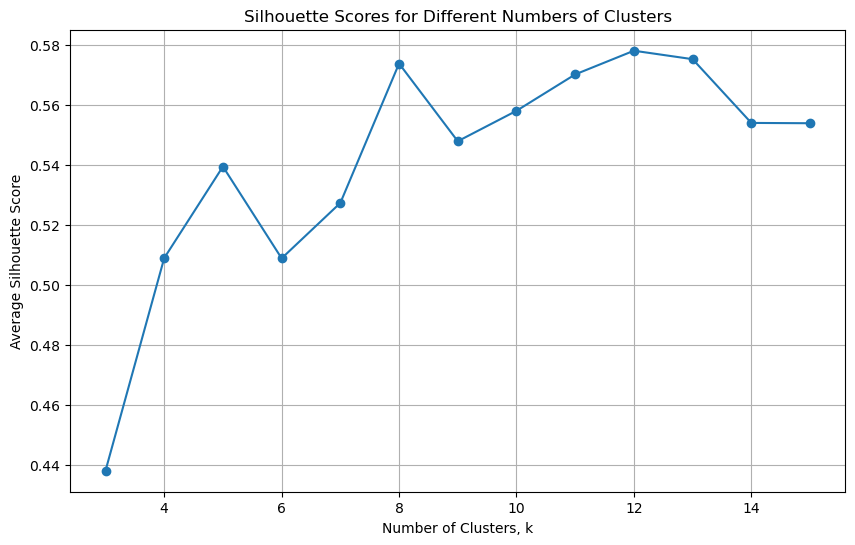

In [24]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'train_data' is your DataFrame containing the categorical data

# One-hot encode all categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_data)
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(train_data.columns))

# Standardize the encoded features
scaler = StandardScaler()
scaled_encoded_categorical_df = scaler.fit_transform(encoded_categorical_df)

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=3, n_neighbors=30, min_dist=0.3, random_state=42)
reduced_data = umap.fit_transform(scaled_encoded_categorical_df)

def test_k_values(reduced_data, max_k):
    silhouette_scores = []
    k_values = range(3, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_data)
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}')
    return k_values, silhouette_scores

# Test k values from 2 to 15
k_values, silhouette_scores = test_k_values(reduced_data, 15)

import matplotlib.pyplot as plt

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()


c:\Users\howar\Anaconda3\envs\gpt\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score for K-means with k=7: 0.5866


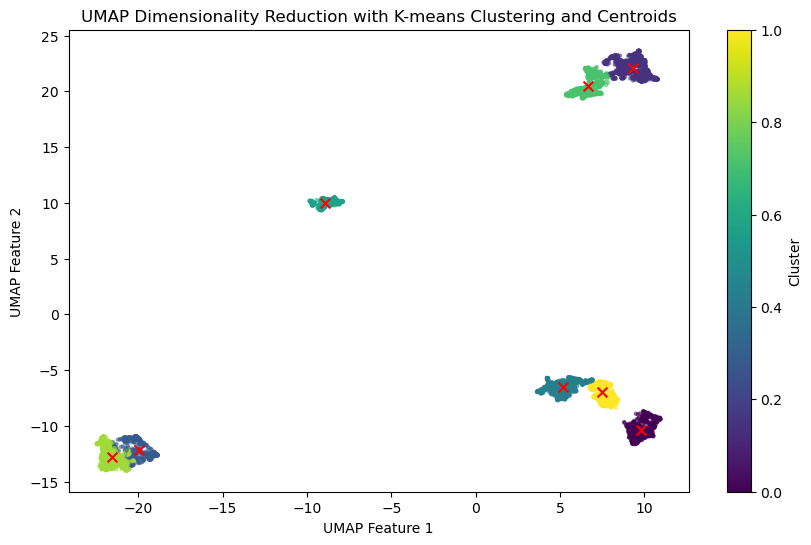

In [26]:
# Assuming demographic_data is your DataFrame containing categorical features
# and clusters column is to be excluded during encoding
categorical_columns = train_data.columns.tolist()

# One-hot encode all categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(train_data[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=3, random_state=42)
reduced_data = umap.fit_transform(encoded_categorical_df)
# 假设 reduced_data 是已经降维处理的数据
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)
centroids = kmeans.cluster_centers_

# 添加聚类标签到原始数据
train_data['clusters'] = cluster_labels
data['clusters'] = cluster_labels

# 计算并打印轮廓系数
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
print(f'Silhouette Score for K-means with k=7: {silhouette_avg:.4f}')

# 绘制UMAP结果、聚类标签和质心
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=5, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, marker='x')  # 以红色'x'标记质心
plt.title('UMAP Dimensionality Reduction with K-means Clustering and Centroids')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.colorbar(label='Cluster')
plt.show()

In [27]:
data[train_data.columns] = train_data

# 分割数据集为7个子数据集
clustered_datasets = {}
for i in range(best_k):
    clustered_datasets[f'Cluster_{i}'] = data[data['clusters'] == i]

# 显示每个子数据集的前几行，验证分割的正确性
for cluster, dataset in clustered_datasets.items():
    print(f"Dataset for {cluster} (first 5 rows):")
    print(dataset.head())
    print("\n")

Dataset for Cluster_0 (first 5 rows):
    File  Row   Q1   Q2   Q3  Q4  FQ1  FQ2  FQ3  ComQ1  ...  Dmed_7  Dmed_8  \
6      1    7  3.0  5.0  4.0   2  2.0  2.0    2    2.0  ...    31.0     128   
27     1   28  5.0  5.0  5.0   3  3.0  1.0    3    1.0  ...    25.0     145   
31     1   32  1.0  5.0  5.0   5  3.0  2.0    3    3.0  ...    33.0     136   
44     1   45  5.0  5.0  5.0   5  3.0  1.0    3    1.0  ...    32.0     205   
66     1   67  5.0  5.0  4.0   5  3.0  4.0    3    1.0  ...    31.0     175   

         DMed_1 DMed_2             DMed_3      DMed_9  Dmed_10  \
6           2-3     No          3-5 times   3-5 hours      2.0   
27    1 or less    Yes  More than 5 times   0-2 hours      3.0   
31  More than 3    Yes  More than 5 times  6-10 hours      3.0   
44  More than 3    Yes          0-2 times  6-10 hours      3.0   
66    1 or less    Yes          3-5 times  6-10 hours      3.0   

               Dmed_5              Dmed_6  clusters  
6          Non-smoker          0-2 d

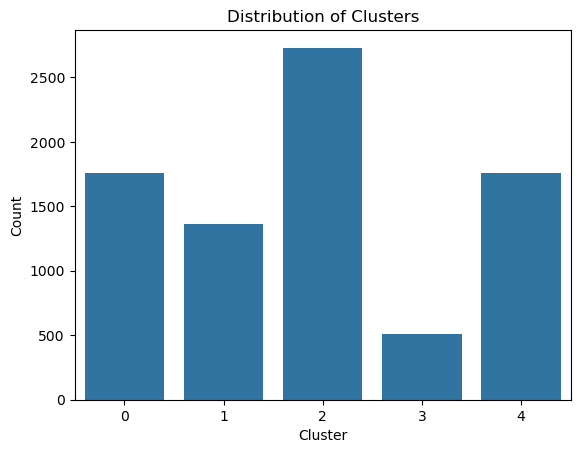

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制条形图
sns.countplot(x='clusters', data=data)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## Significance Testing

               DMed_1 DMed_2             DMed_3     DMed_9 Dmed_10  \
clusters                                                             
0           1 or less    Yes          3-5 times  0-2 hours     3.0   
1           1 or less    Yes          3-5 times  3-5 hours     5.0   
2         More than 3    Yes  More than 5 times  0-2 hours     4.0   
3           1 or less    Yes          3-5 times  3-5 hours     6.0   
4           1 or less    Yes          3-5 times  3-5 hours     7.0   
5           1 or less    Yes  More than 5 times  3-5 hours     5.0   
6           1 or less    Yes          3-5 times  3-5 hours     4.0   
7           1 or less    Yes          3-5 times  0-2 hours     3.0   

              Dmed_5      Dmed_6     HC_1     HC_2     HC_3     HC_4  \
clusters                                                               
0         Non-smoker  0-2 drinks  Neutral  Neutral  Neutral  Neutral   
1         Non-smoker  0-2 drinks    Agree  Neutral    Agree  Neutral   
2         N

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


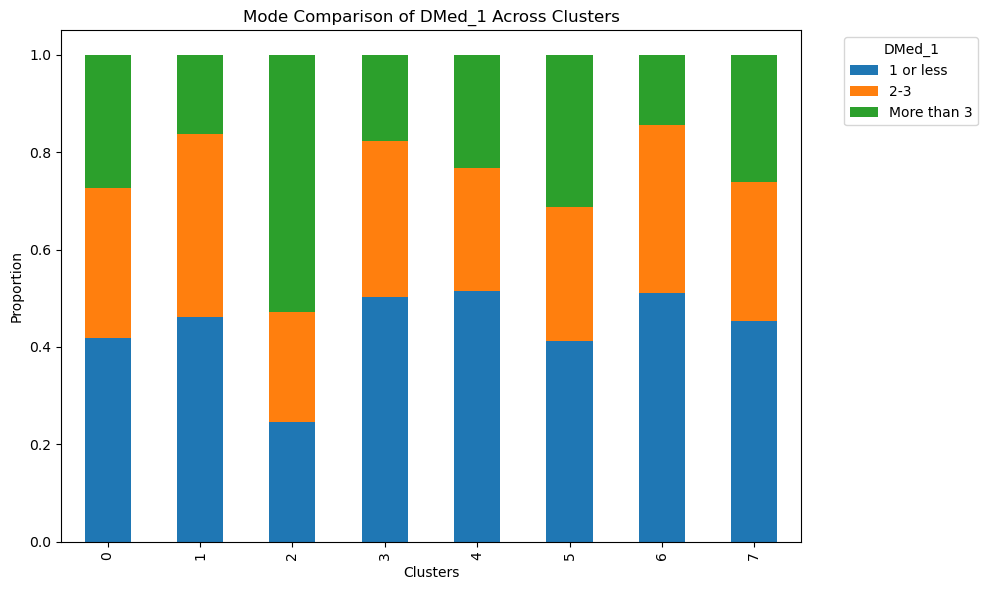

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


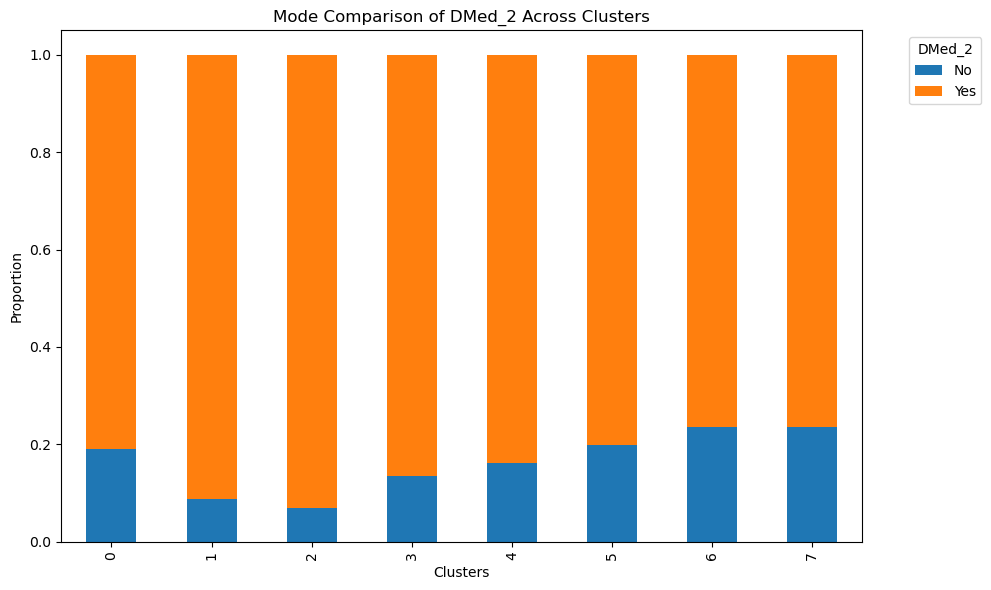

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


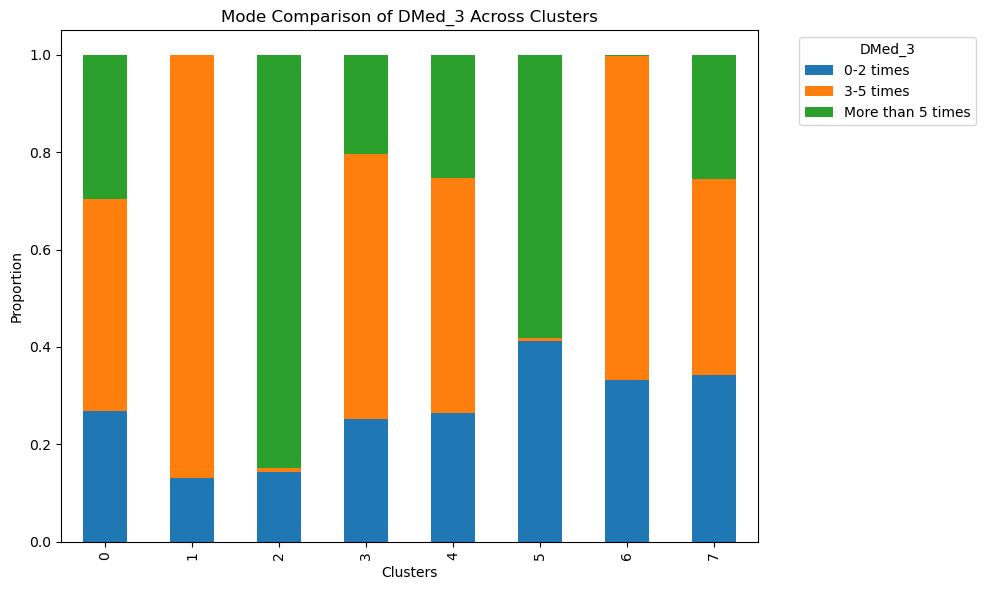

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


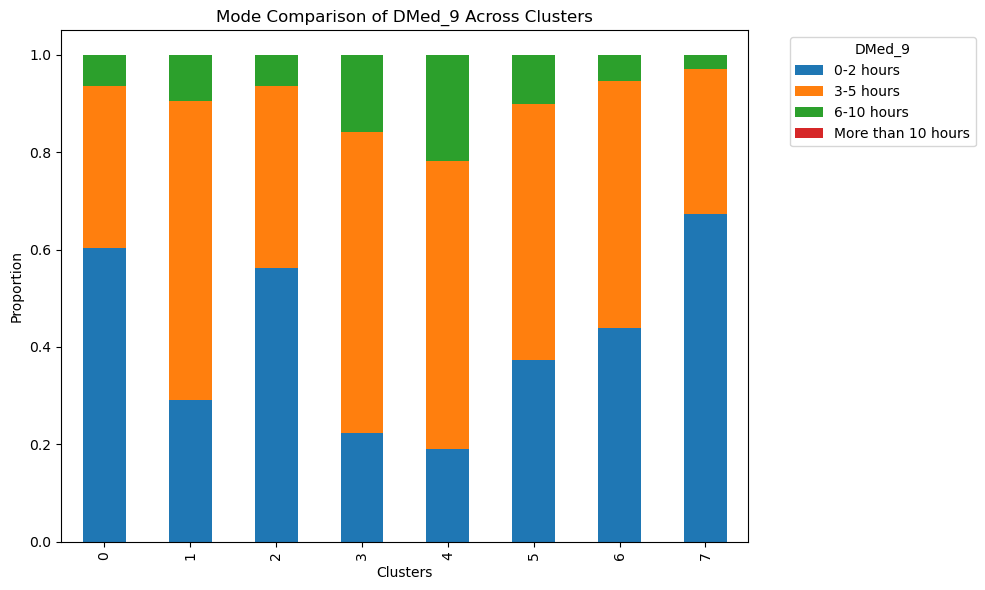

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


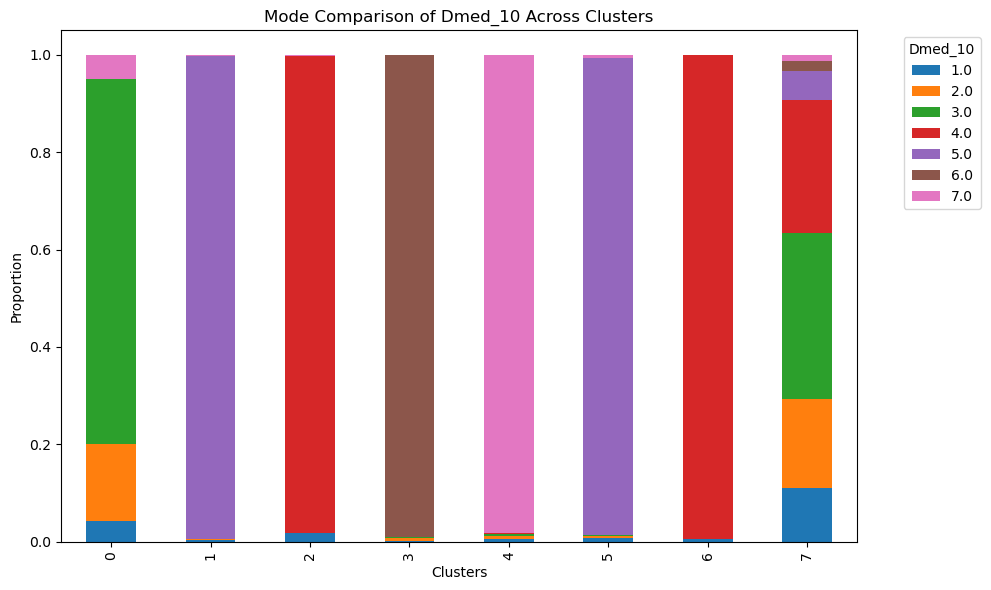

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


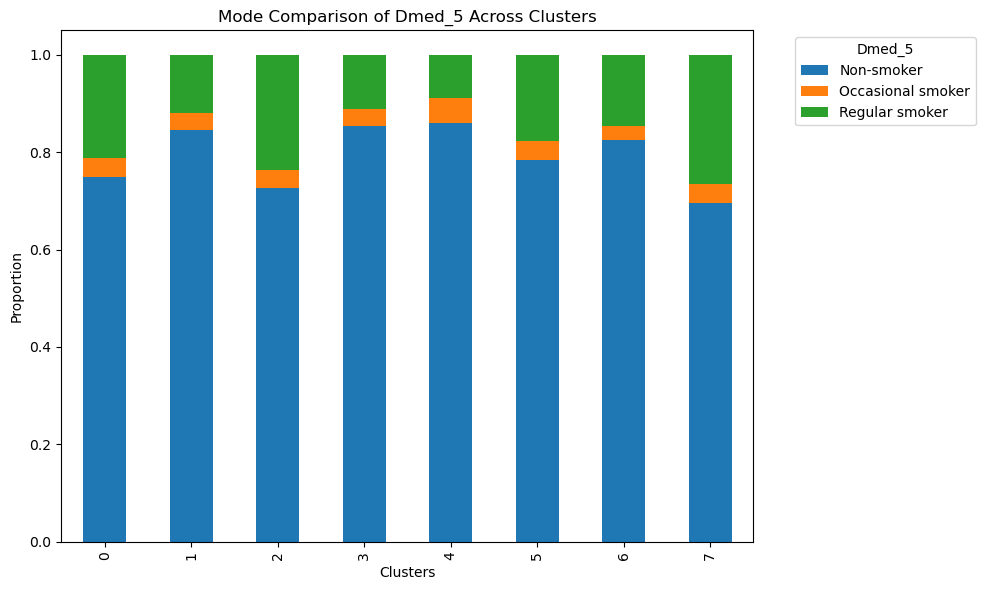

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


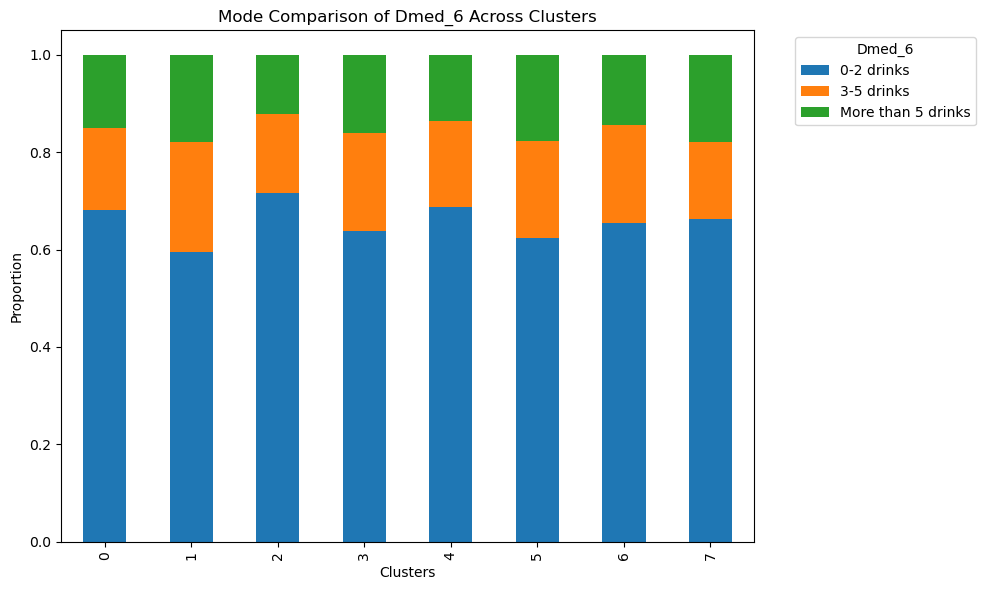

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


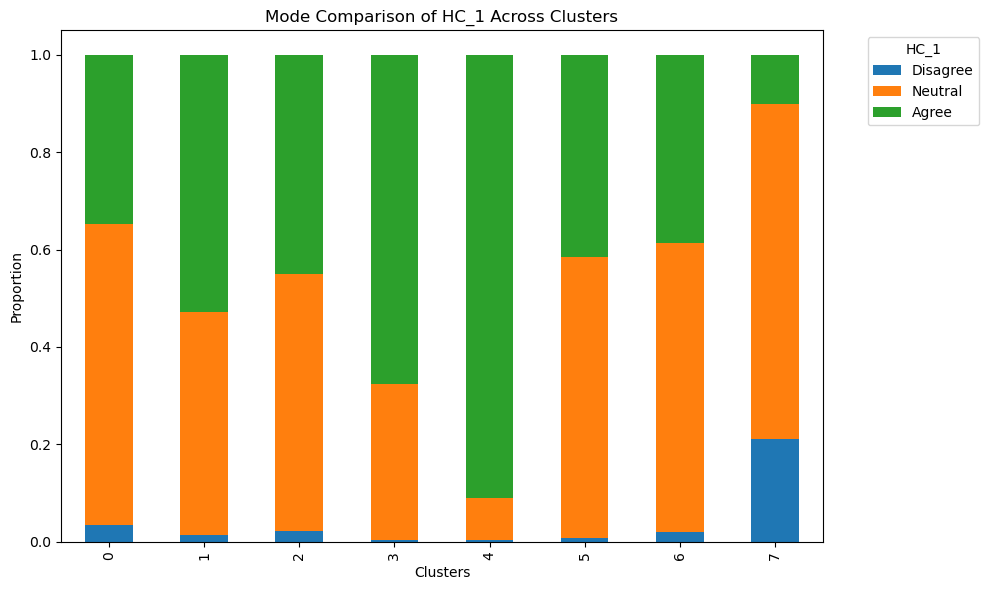

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


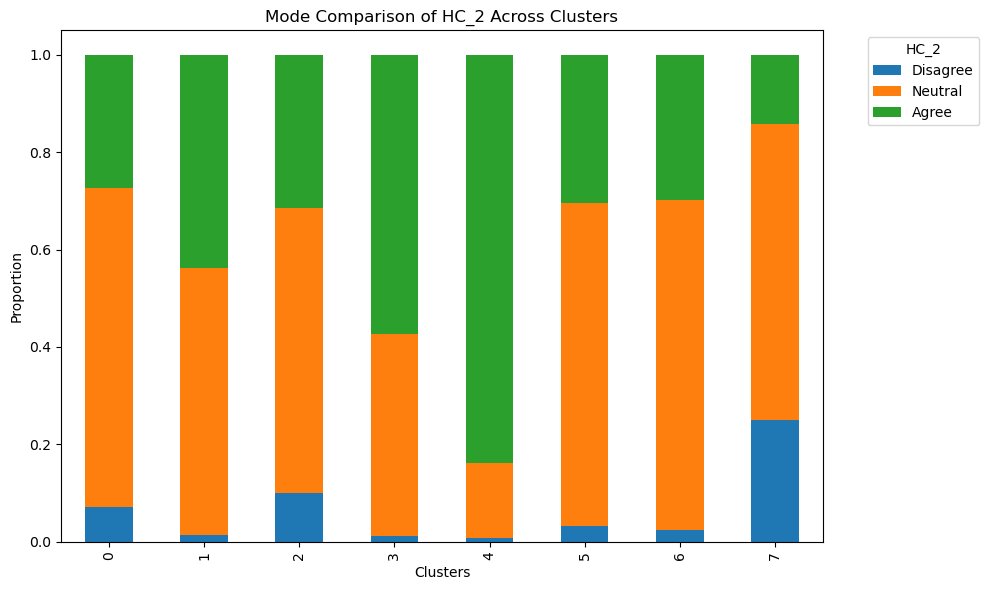

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


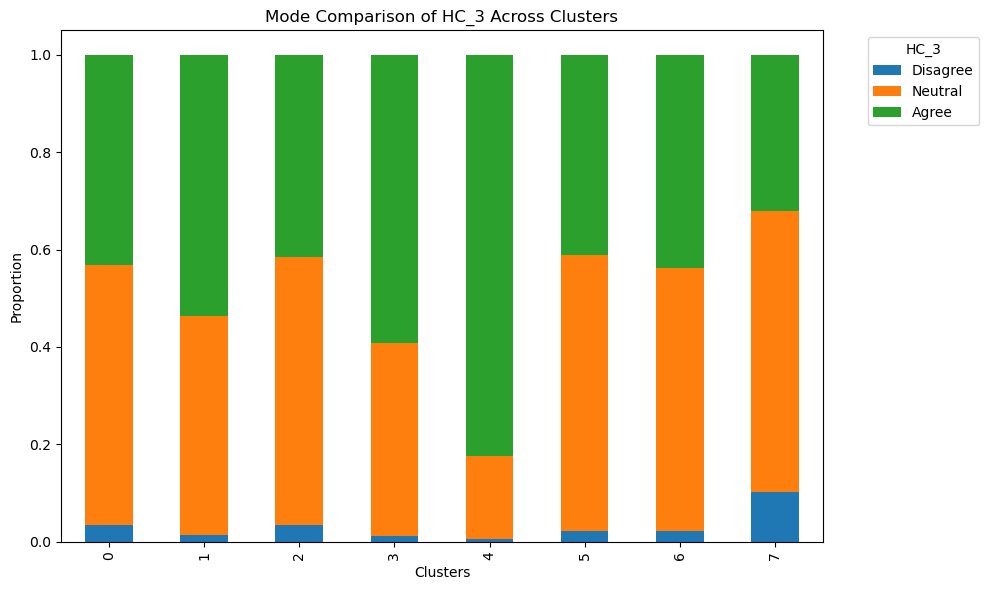

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


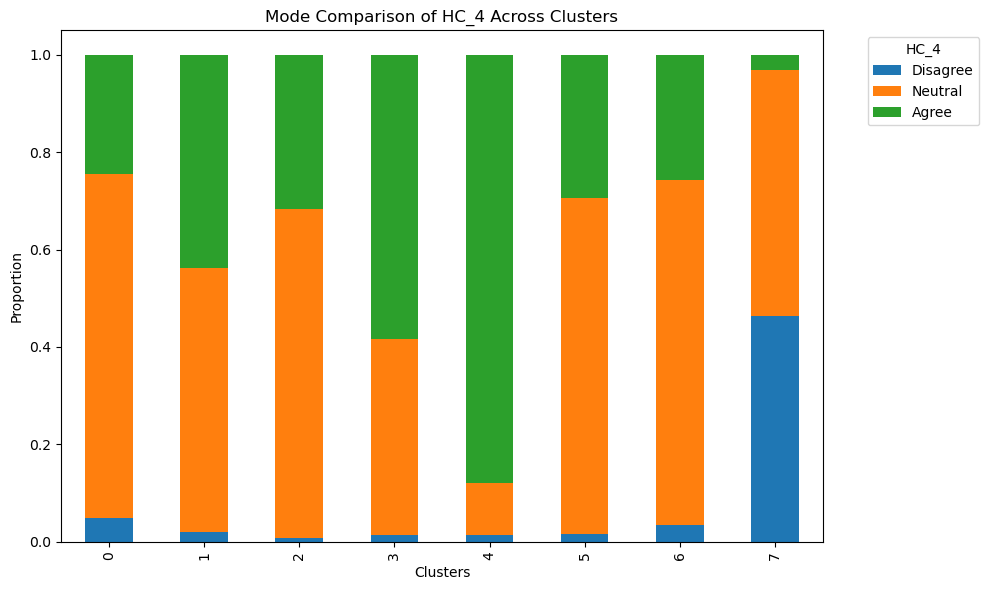

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


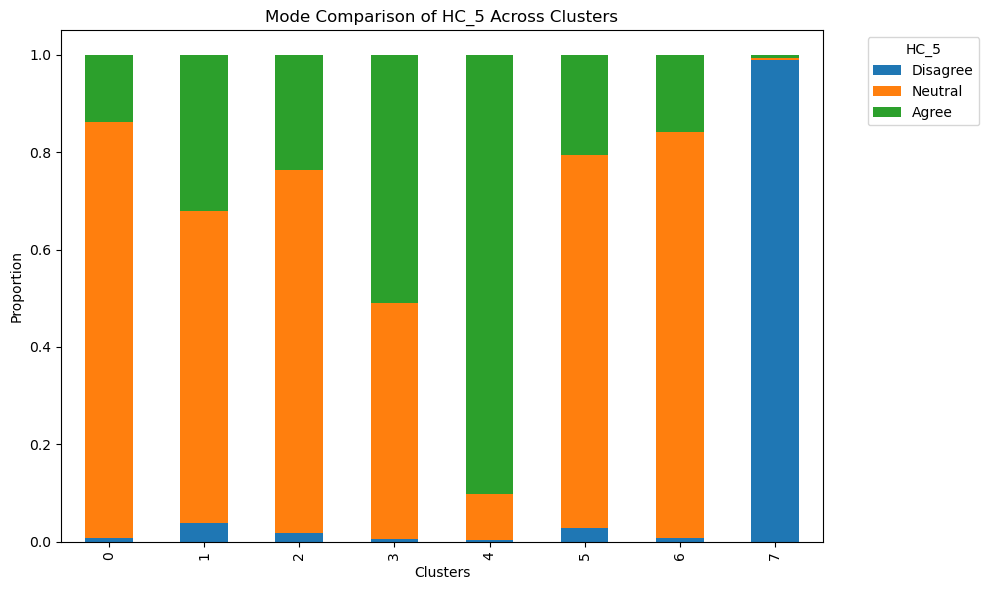

C:\Users\howar\AppData\Local\Temp\ipykernel_23956\1234525229.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)


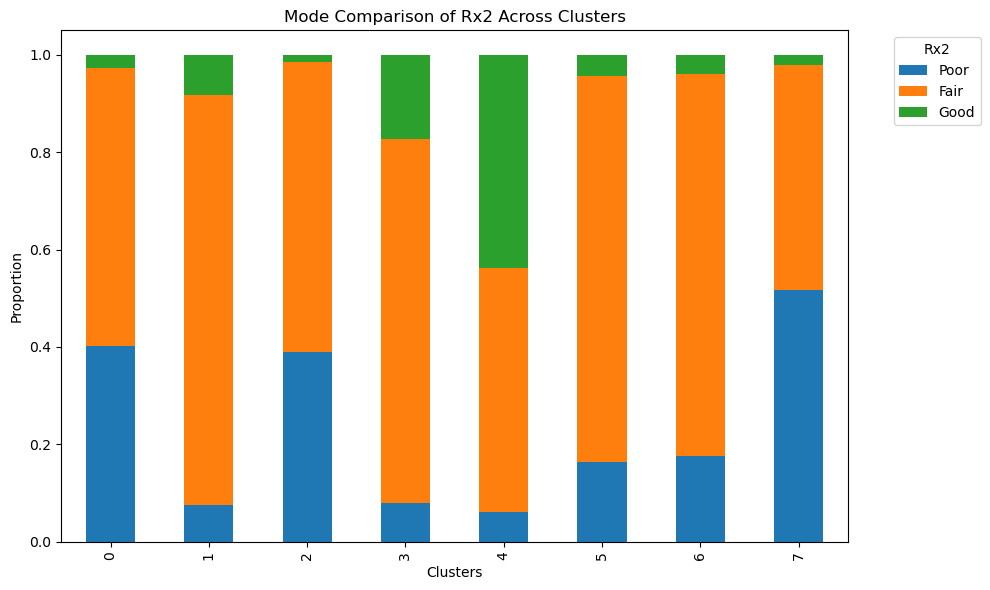

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


# 创建原数据的副本
mapped_data = train_data.copy()

# 提取特征和群集标签
demographic_features = mapped_data.columns.tolist()
clusters = mapped_data['clusters']

# 计算每个群集中类别特征的众数（模式）
categorical_centroids = mapped_data.groupby(clusters).agg(lambda x: x.mode()[0])

# 显示众数表
print(categorical_centroids)

# 可视化每个类别特征在不同群集中的众数比例
for feature in demographic_features:
    if feature == 'clusters':
        continue
    mode_counts = mapped_data.groupby(['clusters', feature]).size().unstack(fill_value=0)
    mode_counts = mode_counts.div(mode_counts.sum(axis=1), axis=0)  # 归一化以进行百分比比较

    mode_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Mode Comparison of {feature} Across Clusters')
    plt.xlabel('Clusters')
    plt.ylabel('Proportion')
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances_argmin_min

# 假设 reduced_data 是UMAP降维后的数据，original_data 是原始数据
# kmeans 是已经在降维数据上训练好的 KMeans 模型
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)

# 假设 original_data 是一个 DataFrame，包含聚类之前的全部原始数据
original_centroids = train_data.iloc[closest]

print("Original data points closest to centroids:")
print(original_centroids)


Original data points closest to centroids:
           DMed_1 DMed_2             DMed_3     DMed_9 Dmed_10      Dmed_5  \
5402    1 or less    Yes          0-2 times  0-2 hours     3.0  Non-smoker   
8244    1 or less    Yes          3-5 times  0-2 hours     5.0  Non-smoker   
3068  More than 3    Yes  More than 5 times  0-2 hours     4.0  Non-smoker   
244     1 or less    Yes          0-2 times  3-5 hours     6.0  Non-smoker   
4492    1 or less    Yes          0-2 times  0-2 hours     7.0  Non-smoker   
3061    1 or less    Yes  More than 5 times  0-2 hours     5.0  Non-smoker   
7544    1 or less    Yes          3-5 times  3-5 hours     4.0  Non-smoker   
6700    1 or less     No          0-2 times  0-2 hours     1.0  Non-smoker   

          Dmed_6      HC_1      HC_2      HC_3     HC_4      HC_5   Rx2  \
5402  0-2 drinks   Neutral     Agree     Agree  Neutral   Neutral  Poor   
8244  3-5 drinks     Agree     Agree     Agree  Neutral   Neutral  Fair   
3068  0-2 drinks  Disagree  D

## 2. Pretrain GPT Model

### GPT4

In [32]:
# 假设 data 是你的Pandas DataFrame
output_dir_train = 'Data\clusters/behavioral_only/train'
output_dir_test = 'Data\clusters/behavioral_only/test'

if not os.path.exists(output_dir_train):
    os.makedirs(output_dir_train)

if not os.path.exists(output_dir_test):
    os.makedirs(output_dir_test)

In [33]:



def convert_to_prompt_behavioral(row):
    intro = "You are someone who "

    # 根据药物数量
    if row['DMed_1'] == '1 or less':
        intro += "takes few or no prescription drugs regularly, "
    elif row['DMed_1'] == '2-3':
        intro += "takes a moderate number of prescription drugs regularly, "
    else:
        intro += "takes many prescription drugs regularly, "

    # 根据是否有主要护理医师
    if row['DMed_2'] == 'Yes':
        intro += "has a primary care physician, "
    else:
        intro += "does not have a primary care physician, "

    # 根据访问医师的频率
    if row['DMed_3'] == '0-2 times':
        intro += "and rarely visits them. "
    elif row['DMed_3'] == '3-5 times':
        intro += "and occasionally visits them. "
    else:
        intro += "and frequently visits them. "

    # 根据运动小时数
    if row['DMed_9'] == '0-2 hours':
        intro += "You engage in little physical activity weekly. "
    elif row['DMed_9'] == '3-5 hours':
        intro += "You have a moderate weekly physical activity. "
    elif row['DMed_9'] == '6-10 hours':
        intro += "You are quite active physically on a weekly basis. "
    else:
        intro += "You are very active, engaging in many hours of physical activity every week. "

    # 结合健康意识
    if row['HC_1'] == 'Agree':
        intro += "Living in the best possible health is very important to you. "

    return intro


In [34]:

# 分割数据集为7个子数据集并进行训练/测试分割
clustered_datasets = {}
train_datasets = {}
test_datasets = {}

for i in range(best_k):  
    cluster_data = data[data['clusters'] == i].head(100)
    train, test = train_test_split(cluster_data, test_size=0.2, random_state=42)  # 20% 数据作为测试集
    train_datasets[f'Cluster_{i}'] = train
    test_datasets[f'Cluster_{i}'] = test


def convert_to_jsonl_format(clustered_datasets, output_dir):
    for cluster, dataset in clustered_datasets.items():
        # Fill missing values
        
        jsonl_data = []
        for index, row in dataset.iterrows():
            system_prompt = "You should simulate a specified person's persona based on the background information I provided. You are currently visiting a psychologist." + convert_to_prompt_behavioral(row)
            # Combining the responses into the completion field
            jsonl_data.append({
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": Text_SubjectiveLit},
                    {"role": "assistant", "content": row['Text_SubjectiveLit']},
                    {"role": "user", "content": Text_TrustPhys},
                    {"role": "assistant", "content": row['Text_TrustPhys']},
                    {"role": "user", "content": Text_Anxiety},
                    {"role": "assistant", "content": row['Text_Anxiety']},
                    {"role": "user", "content": Text_Numeracy},
                    {"role": "assistant", "content": row['Text_Numeracy']}
                ]
                })
                
        # Saving the jsonl files
        filename = os.path.join(output_dir, f"{cluster}.jsonl")
        with open(filename, 'w') as f:
            for entry in jsonl_data:
                f.write(json.dumps(entry) + "\n")
        print(f"Saved {filename}")


# 转换训练数据和测试数据为JSON格式并保存
convert_to_jsonl_format(train_datasets, output_dir_train)
convert_to_jsonl_format(test_datasets, output_dir_test)


Saved Data\clusters/behavioral_only/train\Cluster_0.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_1.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_2.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_3.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_4.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_5.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_6.jsonl
Saved Data\clusters/behavioral_only/train\Cluster_7.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_0.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_1.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_2.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_3.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_4.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_5.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_6.jsonl
Saved Data\clusters/behavioral_only/test\Cluster_7.jsonl


In [35]:
#modify
data_path = "Data\clusters/behavioral_only/train\Cluster_1.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 80
First example:
{'role': 'system', 'content': "You should simulate a specified person's persona based on the background information I provided. You are currently visiting a psychologist.You are someone who takes few or no prescription drugs regularly, has a primary care physician, and occasionally visits them. You have a moderate weekly physical activity. Living in the best possible health is very important to you. "}
{'role': 'user', 'content': 'Regarding all the questions you just answered, to what degree do you feel you have the capacity to obtain, process, and understand basic health information and services needed to make appropriate health decisions? Please explain your answer in a few sentences.'}
{'role': 'assistant', 'content': "I'm very capable of obtaining, processing, and understanding basic health information and services needed to make appropriate health decisions. "}
{'role': 'user', 'content': 'In a few sentences, please explain the reasons why you trust

In [36]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


## 4. Testing results

In [5]:
models = ["ft:gpt-4o-mini-2024-07-18:personal:beha-0:9t1Xo2DY",
          "ft:gpt-4o-mini-2024-07-18:personal:beha-1:9t1Y4432",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-2:9t1XyvZU",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-3:9t2Rt8lu",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-4:9t2S7chM",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-5:9t2Rvqci",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-6:9t2sk1hW",
            "ft:gpt-4o-mini-2024-07-18:personal:beha-7:9t2slSBa",
            "gpt-3.5-turbo-0125"
            ]

user_prompt = {"Text_Numeracy": Text_Numeracy, 
               "Text_Anxiety": Text_Anxiety, 
               "Text_TrustPhys": Text_TrustPhys, 
               "Text_SubjectiveLit": Text_SubjectiveLit}

In [3]:
from openai import OpenAI
import json
from collections import defaultdict

client = OpenAI()

#response from a single person (i = which model, j = resp from jth question)
def perfromace_across_models(models, system_prompt, user_prompt):
  response_list = defaultdict(lambda: {prompt: [] for prompt in user_prompt})
  for i, model in enumerate(models):
    for j in user_prompt:
      response = client.chat.completions.create(
        model= model,
        messages=[{"role": "system", "content": system_prompt}, 
                  {"role": "user", "content": user_prompt[j]}],
        temperature=1,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
      ).choices[0].message.content
      response_list[i][j].append(response)
  
  return response_list


def dict_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: dict_to_regular(v) for k, v in d.items()}
    return d



In [4]:
# Path to the uploaded file
file_paths = [f'Data\clusters/behavioral_only/test\Cluster_{i}.jsonl' for i in range(best_k)]

# Reading the JSONL file and converting it to a list of dictionaries
datas = []

for file_path in file_paths:
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    datas.append(data)

In [5]:
#j = jth cluster
for j, data in enumerate(datas):
    all_responses = []
    all_labels = []

    for i in range(len(data)):
        labels =  {prompt: "" for prompt in user_prompt}
        system_prompt = data[i]["messages"][0]["content"] #peronal information
        q1 = data[i]["messages"][2]["content"]  #answer for q1
        q2 = data[i]["messages"][4]["content"]
        q3 = data[i]["messages"][6]["content"]
        q4 = data[i]["messages"][8]["content"]

        user_response = perfromace_across_models(models, system_prompt, user_prompt)
        #user_response[i][j] = ith model's jth question's  response 
        labels['Text_Numeracy'] = q1
        labels['Text_Anxiety'] = q2
        labels['Text_TrustPhys'] = q3
        labels['Text_SubjectiveLit'] = q4
        
        all_responses.append(user_response)
        all_labels.append(labels)

    all_responses_output_dir = f"results/cluster_{j}/all_responses_beha.json"
    all_labels_output_dir = f"results/cluster_{j}/all_labels_beha.json"

    os.makedirs(os.path.dirname(all_responses_output_dir), exist_ok=True)
    os.makedirs(os.path.dirname(all_labels_output_dir), exist_ok=True)

    # 将 all_responses 中的 defaultdict 转换为普通字典
    all_responses_regular = [dict_to_regular(d) for d in all_responses]

    # 序列化为 JSON 并保存到文件
    with open(all_responses_output_dir, 'w') as f:
        json.dump(all_responses_regular, f)

    with open(all_labels_output_dir, 'w') as f:
        json.dump(all_labels, f)


## Evaluation methods

In [3]:
all_responses = []
all_labels = []

#all_response[clust][i][j][k] = [nth clust][ith person][jth model][kth question]
#all_labels[clust][i][k] = [nth clust][ith person][kth question]

# 从文件中读取并反序列化 JSON 的函数
def regular_to_defaultdict(d):
    if isinstance(d, dict):
        return defaultdict(lambda: {prompt: [] for prompt in user_prompt},
                           {k: regular_to_defaultdict(v) for k, v in d.items()})
    return d

for i in range(best_k):
    # 从文件中读取 JSON 数据并转换回 defaultdict
    with open(f'results/cluster_{i}/all_responses_beha.json', 'r') as f:
        all_responses_loaded = json.load(f)

    with open(f'results/cluster_{i}/all_labels_beha.json', 'r') as f:
        all_labels_loaded = json.load(f)

    all_responses.append([regular_to_defaultdict(d) for d in all_responses_loaded])
    all_labels.append([d for d in all_labels_loaded])

### 1. Text Similarity

In [6]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(paragraph1, paragraph2):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize and prepare the inputs
    inputs1 = tokenizer(paragraph1, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(paragraph2, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Encode the paragraphs using the BERT model
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # Use mean pooling to get sentence embeddings
    embeddings1 = outputs1.last_hidden_state.mean(dim=1).numpy()
    embeddings2 = outputs2.last_hidden_state.mean(dim=1).numpy()

    # Calculate cosine similarity
    similarity = cosine_similarity(embeddings1, embeddings2)
    return similarity


all_similarities_cosine = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(len(models))
        ]

        scores = [[] for _ in range(len(models))]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(len(models)):
                scores[model_idx].append(calculate_similarity(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities_cosine[f"cluster_{clust}"] = similarities

In [7]:
all_responses

[[defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
              {'0': defaultdict(<function __main__.regular_to_defaultdict.<locals>.<lambda>()>,
                           {'Text_Numeracy': ['When I was pregnant, I decided to do a lot of research to make informed decisions about the steps I would take.  I read a lot about the effects of certain drugs and Vaccines on fetuses.  I also learned about the effects of certain conditions, like gestational diabetes, on fetuses.'],
                            'Text_Anxiety': ['Tests results,especially blood tests. Also the waiting to see the doctor. The doctor my feel like breaking bad news to you.'],
                            'Text_TrustPhys': ['he is always caring, and explains everything carefully and also listen to his patients concerning what they are feeling and how the treatment has been, and give attention to their response'],
                            'Text_SubjectiveLit': ['I Understand a lot and someti

In [ ]:
''' 
structure of all_similarities
{
    "cluster_0": [
        # Person 0 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],  # model 0 scores
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],  # model 1 scores
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],  # model 2 scores
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],  # model 3 scores
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]  # regular model scores
        ],
        # Person 1 in cluster_0
        [
            [similarity_Numeracy_model0, similarity_Anxiety_model0, similarity_TrustPhys_model0, similarity_SubjectiveLit_model0],
            [similarity_Numeracy_model1, similarity_Anxiety_model1, similarity_TrustPhys_model1, similarity_SubjectiveLit_model1],
            [similarity_Numeracy_model2, similarity_Anxiety_model2, similarity_TrustPhys_model2, similarity_SubjectiveLit_model2],
            [similarity_Numeracy_model3, similarity_Anxiety_model3, similarity_TrustPhys_model3, similarity_SubjectiveLit_model3],
            [similarity_Numeracy_regular, similarity_Anxiety_regular, similarity_TrustPhys_regular, similarity_SubjectiveLit_regular]
        ],
        # More people in cluster_0
    ],
    "cluster_1": [
        # Similar structure as cluster_0
    ],
    # More clusters
}

'''

In [10]:

# Calculate average similarities for each model in each cluster
best_models = {}

for clust, sim_list in all_similarities_cosine.items():
    cluster_similarities = np.array(sim_list)
    average_model_similarities = np.mean(cluster_similarities, axis=(0, 1))  # Axis 0 is people, axis 1 is fields

    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx

    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)

Cluster cluster_0, Best model: model0 with average similarity: [[0.752343]]
Cluster cluster_1, Best model: model1 with average similarity: [[0.75521815]]
Cluster cluster_2, Best model: model0 with average similarity: [[0.74436146]]
Cluster cluster_3, Best model: model2 with average similarity: [[0.7301314]]
Cluster cluster_4, Best model: model0 with average similarity: [[0.73810554]]
Cluster cluster_5, Best model: model0 with average similarity: [[0.75506914]]
Cluster cluster_6, Best model: model1 with average similarity: [[0.74754214]]
Cluster cluster_7, Best model: model1 with average similarity: [[0.75241905]]
Best models for all clusters: {'cluster_0': 0, 'cluster_1': 1, 'cluster_2': 0, 'cluster_3': 2, 'cluster_4': 0, 'cluster_5': 0, 'cluster_6': 1, 'cluster_7': 1}


### 2. LLM as judge? comparing responses between label & different models

Dimensions：
1. similarity on decision
2. similarity on personality
3. hallucination
4. stability


In [7]:
judger = OpenAI()
system_judger_prompt = "You are a professional psychologist with extensive experience in evaluating textual responses for various psychological and cognitive dimensions. "

def get_response(judger, message):
    response = judger.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_judger_prompt},
            {"role": "user", "content": message}
        ]
    )
    return response.choices[0].message.content

def extract_numeric_score(response_text):
    match = re.search(r"(\d+(\.\d+)?)", response_text)
    if match:
        return float(match.group(1))
    else:
        return 0.0
    
def calculate_similarity_llm(label, answer):
    dimensions = ["similarity on decision", "similarity on personality", "hallucination", "stability"]
    scores = []
    for dimension in dimensions:
        message = f"Evaluate the following model response based on the dimension of '{dimension}' comparing to the label response:\n\nLabel response: {label}\nModel response: {answer}\n\nScore (1-10). Please only output the number."
        score_text = get_response(judger, message)
        score = extract_numeric_score(score_text)
        scores.append(score)
    return sum(scores) / len(scores)

In [11]:
all_similarities = {f"cluster_{j}" : [] for j in range(best_k)}

for clust in range(len(all_labels)):
    similarities = []
    for i, person in enumerate(all_labels[clust]):
        label = [person["Text_Numeracy"], person["Text_Anxiety"], person["Text_TrustPhys"], person["Text_SubjectiveLit"]]
        
        answer_models = [
            [all_responses[clust][i][str(model_idx)]["Text_Numeracy"],
             all_responses[clust][i][str(model_idx)]["Text_Anxiety"],
             all_responses[clust][i][str(model_idx)]["Text_TrustPhys"],
             all_responses[clust][i][str(model_idx)]["Text_SubjectiveLit"]]
            for model_idx in range(5)
        ]

        scores = [[] for _ in range(5)]  # 存放5个模型的分数

        for j in range(len(label)):
            for model_idx in range(5):
                scores[model_idx].append(calculate_similarity_llm(label[j], answer_models[model_idx][j]))

        similarities.append(scores)  # 包含所有模型的分数
    all_similarities[f"cluster_{clust}"] = similarities


In [12]:
import numpy as np

best_models = {}
all_scores = {}

for clust, sim_list in all_similarities.items():
    cluster_similarities = np.array(sim_list)
    
    # Calculate the mean similarity for each model across all fields for each person
    mean_similarities_per_person = np.mean(cluster_similarities, axis=2)
    
    # Calculate the average similarity for each model across all people
    average_model_similarities = np.mean(mean_similarities_per_person, axis=0)
    
    best_model_idx = np.argmax(average_model_similarities)
    best_models[clust] = best_model_idx
    all_scores[clust] = average_model_similarities

    print(f"Cluster {clust}, Model scores: {average_model_similarities}")
    print(f"Cluster {clust}, Best model: model{best_model_idx} with average similarity: {average_model_similarities[best_model_idx]}")

# Print the best models for all clusters
print("Best models for all clusters:", best_models)


Cluster cluster_0, Model scores: [2.6625  2.725   2.7375  3.35    3.49375]
Cluster cluster_0, Best model: model4 with average similarity: 3.49375
Cluster cluster_1, Model scores: [2.425    2.771875 2.728125 3.378125 3.84375 ]
Cluster cluster_1, Best model: model4 with average similarity: 3.84375
Cluster cluster_2, Model scores: [2.7421875 2.7625    2.5765625 3.4375    3.75     ]
Cluster cluster_2, Best model: model4 with average similarity: 3.75
Best models for all clusters: {'cluster_0': 4, 'cluster_1': 4, 'cluster_2': 4}
